In [1]:
base_dir = '/glade/work/kjmayer/research/catalyst/S2S_ocn_lnd_atm/'

In [2]:
import xarray as xr
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torchinfo
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from model.train_utils import NeuralNetwork
import utils.utils
from utils.utils import get_config
from utils.utils import prepare_device
from trainer.trainer import Trainer
import model.metrics as module_metric
from data_prep.data_loader import GetXData, GetYData, CustomDataset,lead_shift, concat_input

In [3]:
# torch.cuda.is_available()
# torch.cuda.device_count()
# torch.cuda.current_device()
# torch.cuda.device(0)
torch.cuda.get_device_name(0)

'NVIDIA A100-SXM4-80GB'

In [34]:
config = get_config("exp_1")

torch.manual_seed(config["seed"])
torch.cuda.manual_seed(config["seed"])
np.random.seed(config["seed"])
random.seed(config["seed"])
torch.backends.cudnn.deterministic = True

In [17]:
LEAD = config["data_loader"]["lead"][0] # will loop over this for training eventually
trainfinames = config["data_loader"]["anommems_finames"][0:6]
valfinames = config["data_loader"]["anommems_finames"][6:8]

xtrain, xtrainmean, xtrainstd, xtrainmin, xtrainmax = GetXData(dir=config["data_loader"]["base_dir"],
                                                              var=config["data_loader"]["atm_var"],
                                                              finames=trainfinames,
                                                              train=True,
                                                              climo=False)[0]
# xtrain = xtrain.stack(l=('lat','lon'))
xtrain_shift = lead_shift(xtrain, lead=LEAD, forward=False)

ytrain, ytrainmean, ytrainstd = GetYData(dir=config["data_loader"]["base_dir"],
                                         var=config["data_loader"]["atm_var"],
                                         finames=trainfinames,
                                         train=True)[0]

ytrain = ytrain.sel(lat=slice(29,61))
ytrain = ytrain.stack(l=('lat','lon'))
ytrain_shift = lead_shift(ytrain, lead=LEAD, forward=True)

xval = GetXData(dir=config["data_loader"]["base_dir"],
               var=config["data_loader"]["atm_var"],
               finames=valfinames,
               train=False,
               trainmean=xtrainmean,
               trainstd=xtrainstd,
               trainmin=xtrainmin,
               trainmax=xtrainmax,
               climo=False)[0]
# 
xval_shift = lead_shift(xval, lead=LEAD, forward=False)

yval = GetYData(dir=config["data_loader"]["base_dir"],
                var=config["data_loader"]["atm_var"],
                finames=trainfinames,
                train=False,
                trainmean=ytrainmean,
                trainstd=ytrainstd)[0]

yval = yval.sel(lat=slice(29,61))
yval = yval.stack(l=('lat','lon'))
yval_shift = lead_shift(yval, lead=LEAD, forward=True)


# climo (same for train, val, and test --> basically a DOY encoder)
xclimo, climomin, climomax = GetXData(dir = config["data_loader"]["base_dir"],
                                     var = config["data_loader"]["atm_var"],
                                     finames = config["data_loader"]["climo_finame"],
                                     train = False, # MUST ALWAYS BE False FOR CLIMO
                                     climo = True)[0]
# climo appended to same length as training
xclimo = xclimo.rename({'dayofyear': 'time'})
xclimo_train = xr.concat([xclimo]*int(xtrain.shape[0]/365),dim='mem')
xclimo_train = xclimo_train.stack(s=('mem','time')).transpose('s', 'lat', 'lon').reset_index(['s'])
xclimo_train_shift = lead_shift(xclimo_train,lead=LEAD,forward=False)

# climo appended to same length as validation
xclimo_val = xr.concat([xclimo]*int(xval.shape[0]/365),dim='mem')
xclimo_val = xclimo_val.stack(s=('mem','time')).transpose('s', 'lat', 'lon').reset_index(['s'])
xclimo_val_shift = lead_shift(xclimo_val,lead=LEAD,forward=False)

/glade/work/wchapman/miniconda3.1/envs/MLWPS/lib/python3.11/site-packages/xarray/core/variable.py:1546: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  result = result._stack_once(dims, new_dim)
/glade/work/wchapman/miniconda3.1/envs/MLWPS/lib/python3.11/site-packages/xarray/core/variable.py:1546: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shap

In [18]:
Xtrain = concat_input(xtrain_shift,xclimo_train_shift,dim_name='features').values
del xtrain_shift,xclimo_train_shift
Xval = concat_input(xval_shift,xclimo_val_shift,dim_name='features').values
del xval_shift,xclimo_val_shift
Ytrain = ytrain_shift.values
del ytrain_shift
Yval = yval_shift.values
del yval_shift

In [19]:
## Prep training and validation for ANN
training_data = CustomDataset(Xtrain,Ytrain) #xtrain, ytrain need to be numpy, not xarray
val_data = CustomDataset(Xval,Yval)

#[batch_size,channels,lat,lon]
train_dataloader = DataLoader(training_data,batch_size = config["data_loader"]["batch_size"],shuffle=True)
val_dataloader  = DataLoader(val_data,batch_size = config["data_loader"]["batch_size"],shuffle=True)

In [20]:
# check shapes
for input, output in training_data:
    print(np.shape(input))
    print(np.shape(output))
    break

train_features, train_labels = next(iter(train_dataloader))
print(np.shape(train_features))
print(np.shape(train_labels))

torch.Size([2, 96, 144])
torch.Size([2448])
torch.Size([32, 2, 96, 144])
torch.Size([32, 2448])


In [59]:
## create NN architecture
config = get_config("exp_1")
# print(config["arch_atm"])
model = NeuralNetwork(config=config["arch_atm"])

## grab optimizer and loss 
optimizer = getattr(torch.optim, config["optimizer"]["type"])(
    model.parameters(), **config["optimizer"]["args"]
)
criterion = getattr(torch.nn, config["criterion"])()

metric_funcs = [getattr(module_metric, met) for met in config["metrics"]]

## Build the trainer
device = prepare_device(config["device"])
trainer = Trainer(
    model,
    criterion,
    metric_funcs,
    optimizer,
    max_epochs=config["trainer"]["max_epochs"],
    data=train_dataloader,
    validation_data=val_dataloader,
    device=device,
    config=config,
)

# Visualize the model
torchinfo.summary(
    model,
    input_size=(config["data_loader"]["batch_size"], 2, 96, 144),
    verbose=1,
    col_names=("input_size", "output_size", "num_params"),
)

#Train the Model
model.to(device)
trainer.fit()

{'type': 'cnn', 'circular_padding': [5, 5, 0, 0], 'n_inputchannel': 2, 'filters': [32, 32], 'kernel_size': [5, 5], 'cnn_act': ['ReLU', 'ReLU'], 'hiddens_block_in': [7680, 100], 'hiddens_block': [100], 'hiddens_block_act': ['ReLU'], 'hiddens_final': 2448, 'hiddens_final_in': 100, 'hiddens_final_act': False}
device available : True
device count:  1
current device:  0
device name:  NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
Memory Usage:
Allocated: 0.1 GB
Cached:    1.5 GB
using device:  cuda
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NeuralNetwork                            [128, 2, 96, 144]         [128, 2448]               --
├─CircularPad2d: 1-1                     [128, 2, 96, 144]         [128, 2, 96, 154]         --
├─Sequential: 1-2                        [128, 2, 96, 154]         [128, 32, 24, 39]         --
│    └─Sequential: 2-1                   [128, 2, 96, 154]         [128, 32, 48, 77]         --
│    │    └─Conv2d:

dict_keys(['epoch', 'loss', 'val_loss', 'MAE', 'val_MAE'])


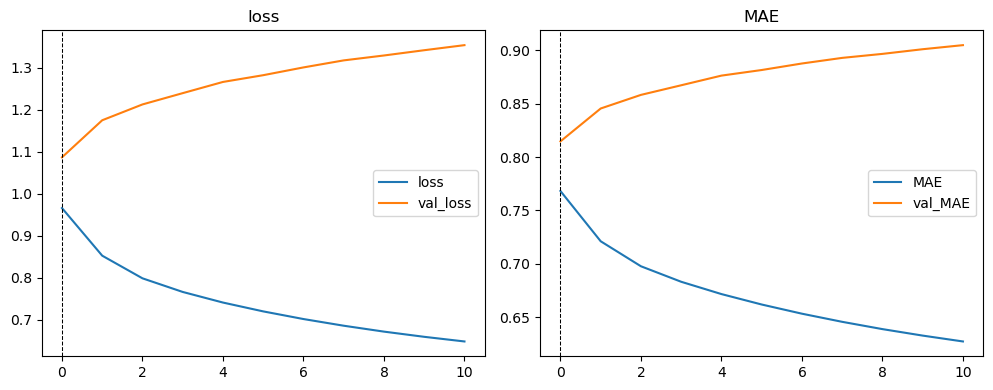

In [60]:
print(trainer.log.history.keys())

plt.figure(figsize=(20, 4))
for i, m in enumerate(("loss", *config["metrics"])):
    plt.subplot(1, 4, i + 1)
    plt.plot(trainer.log.history["epoch"], trainer.log.history[m], label=m)
    plt.plot(
        trainer.log.history["epoch"], trainer.log.history["val_" + m], label="val_" + m
    )
    plt.axvline(
        x=trainer.early_stopper.best_epoch, linestyle="--", color="k", linewidth=0.75
    )
    plt.title(m)
    plt.legend()
plt.tight_layout()
plt.show()

In [48]:
with torch.inference_mode():
    val_pred = model.predict(dataset=val_data, batch_size=config["data_loader"]["batch_size"], device=device)

In [49]:
print(np.shape(val_pred))
print(np.shape(val_pred[0]))

(47449, 2448)
(2448,)


In [55]:
# ytrainmax = xtrainmax.sel(lat=slice(29,61)).values
# ytrainmin = xtrainmin.sel(lat=slice(29,61)).values

In [51]:
isample = 133

In [52]:
val_pred_reshape = val_pred[isample].reshape((17,144))
# val_pred_denorm = (val_pred_reshape*(ytrainmax-ytrainmin)) + ytrainmin

Yval_reshape = Yval[isample].reshape((17,144))
# Yval_denorm = (Yval_reshape*(ytrainmax-ytrainmin)) + ytrainmin

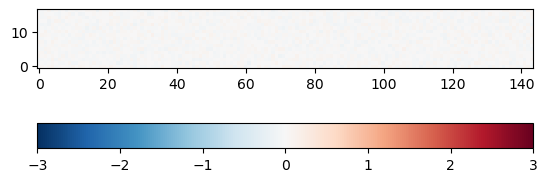

In [53]:
plt.imshow(val_pred_reshape,origin='lower',cmap='RdBu_r',vmin=-3,vmax=3)
plt.colorbar(orientation='horizontal')

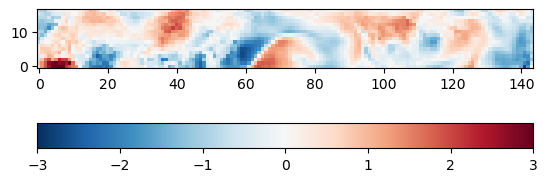

In [54]:
plt.imshow(Yval_reshape,origin='lower',cmap='RdBu_r',vmin=-3,vmax=3)
plt.colorbar(orientation='horizontal')

In [ ]:
# compare
ydiff = val_pred_reshape - Yval_reshape
plt.imshow(ydiff,origin='lower',cmap='RdBu_r')
plt.colorbar(orientation='horizontal')

In [31]:
# plt.imshow(val_pred_denorm,origin='lower',cmap='RdBu_r',vmin=-3,vmax=3)
# plt.colorbar(orientation='horizontal')

In [32]:
# plt.imshow(Yval_denorm,origin='lower',cmap='RdBu_r',vmin=-3,vmax=3)
# plt.colorbar(orientation='horizontal')

In [33]:
# ydiff_denorm = val_pred_denorm - Yval_denorm
# plt.imshow(ydiff_denorm,origin='lower',cmap='RdBu_r')
# plt.colorbar(orientation='horizontal')